In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [49]:
df_train = pd.read_csv("emotions/train.txt", delimiter=';', header=None, names=['sentence','label'])

In [3]:
df_train.head()

,sentence,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


### Lets look how many each of emotions are represented in dataset

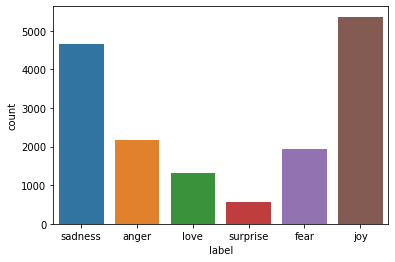

In [4]:
sns.countplot(df_train['label'])

### Prepare our data

In [5]:
from nltk.corpus import stopwords 
import string

In [6]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    word_seq=[word for word in nopunc.split() if word.lower() not in stopwords.words('english')]
    return word_seq

In [7]:
text=df_train['sentence'].apply(text_process)

In [8]:
text

0                                [didnt, feel, humiliated]
1        [go, feeling, hopeless, damned, hopeful, aroun...
2        [im, grabbing, minute, post, feel, greedy, wrong]
3        [ever, feeling, nostalgic, fireplace, know, st...
4                                       [feeling, grouchy]
                               ...                        
15995    [brief, time, beanbag, said, anna, feel, like,...
15996    [turning, feel, pathetic, still, waiting, tabl...
15997                        [feel, strong, good, overall]
15998                [feel, like, rude, comment, im, glad]
15999                   [know, lot, feel, stupid, portray]
Name: sentence, Length: 16000, dtype: object

In [10]:
import warnings
warnings.filterwarnings('ignore')
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [11]:
max_len=100
max_words=20000
tokenizer=Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(text)
sequences=tokenizer.texts_to_sequences(text)

In [12]:
data=pad_sequences(sequences,maxlen=max_len)

In [13]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

In [14]:
encode=LabelEncoder()

In [15]:
y=encode.fit_transform(df_train['label'])
y_data=np_utils.to_categorical(y)
y_data.shape

(16000, 6)

In [16]:
y_data

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.]], dtype=float32)

In [17]:
len(data)

16000

In [18]:
len(y_data)

16000

In [19]:
x_train=data[:13000]
y_train=y_data[:13000]
x_val=data[13000:]
y_val=y_data[13000:]

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,Dropout,Dense,Bidirectional,LSTM
from tensorflow.keras.callbacks import EarlyStopping

### Creating a model

In [21]:
model=Sequential()
model.add(Embedding(max_words,64,input_length=max_len))
model.add(Bidirectional(LSTM(100)))
model.add(Dropout(0.5))
model.add(Dense(32,activation='relu'))
model.add(Dense(y_data.shape[1],activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 64)           1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               132000    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                6432      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 1,418,630
Trainable params: 1,418,630
Non-trainable params: 0
_________________________________________________________________


In [23]:
es=EarlyStopping(monitor='val_loss')

In [24]:
predictions=model.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=30,callbacks=[es])

Train on 13000 samples, validate on 3000 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/30
13000/13000 [==============================] - 174s 13ms/sample - loss: 1.3645 - acc: 0.4628 - val_loss: 0.7321 - val_acc: 0.7570
Epoch 2/30
13000/13000 [==============================] - 170s 13ms/sample - loss: 0.4493 - acc: 0.8551 - val_loss: 0.3380 - val_acc: 0.8863
Epoch 3/30
13000/13000 [==============================] - 170s 13ms/sample - loss: 0.1895 - acc: 0.9418 - val_loss: 0.2943 - val_acc: 0.9097
Epoch 4/30
13000/13000 [==============================] - 171s 13ms/sample - loss: 0.1136 - acc: 0.9652 - val_loss: 0.3120 - val_acc: 0.9050


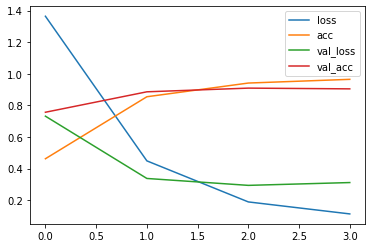

In [25]:
losses=pd.DataFrame(model.history.history)
losses.plot()

In [26]:
df_test= pd.read_csv("emotions/test.txt", delimiter=';', header=None, names=['sentence','label'])

In [27]:
df_test

,sentence,label
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness
...,...,...
1995,i just keep feeling like someone is being unki...,anger
1996,im feeling a little cranky negative after this...,anger
1997,i feel that i am useful to my people and that ...,joy
1998,im feeling more comfortable with derby i feel ...,joy


In [28]:
testing_text=df_test['sentence'].apply(text_process)

In [29]:
len(testing_text)

2000

In [30]:
tokenizer=Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(testing_text)
test_sequences=tokenizer.texts_to_sequences(testing_text)
test_data=pad_sequences(test_sequences,maxlen=max_len)
testing_labels=encode.fit_transform(df_test['label'])
testing_labels=np_utils.to_categorical(testing_labels)
testing_labels.shape

(2000, 6)

In [31]:
test_predictions=model.fit(test_data,testing_labels,epochs=30,callbacks=[es])

Epoch 1/30
2000/2000 [==============================] - 25s 12ms/sample - loss: 2.0125 - acc: 0.3165
Epoch 2/30
2000/2000 [==============================] - 25s 12ms/sample - loss: 1.5364 - acc: 0.3675
Epoch 3/30
2000/2000 [==============================] - 25s 12ms/sample - loss: 1.4794 - acc: 0.4095
Epoch 4/30
2000/2000 [==============================] - 25s 12ms/sample - loss: 1.3753 - acc: 0.4720
Epoch 5/30
2000/2000 [==============================] - 25s 12ms/sample - loss: 1.1604 - acc: 0.5820
Epoch 6/30
2000/2000 [==============================] - 25s 12ms/sample - loss: 0.8622 - acc: 0.7125
Epoch 7/30
2000/2000 [==============================] - 25s 12ms/sample - loss: 0.5745 - acc: 0.8150
Epoch 8/30
2000/2000 [==============================] - 25s 12ms/sample - loss: 0.3817 - acc: 0.8790
Epoch 9/30
2000/2000 [==============================] - 25s 12ms/sample - loss: 0.2497 - acc: 0.9215
Epoch 10/30
2000/2000 [==============================] - 25s 12ms/sample - loss: 0.1606 - a

Epoch 28/30
2000/2000 [==============================] - 25s 12ms/sample - loss: 0.0033 - acc: 0.9995
Epoch 29/30
2000/2000 [==============================] - 25s 12ms/sample - loss: 0.0030 - acc: 1.0000
Epoch 30/30
2000/2000 [==============================] - 25s 12ms/sample - loss: 0.0018 - acc: 1.0000


In [32]:
encode.classes_

array(['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'],
      dtype=object)

In [33]:
model.save('NLPemot.model')

In [48]:
df_val = pd.read_csv("emotions/val.txt", delimiter=';', header=None, names=['sentence','label'])

In [50]:
val_text=df_val['sentence'].apply(text_process)

In [51]:
tokenizer.fit_on_texts(val_text)
val_sequences=tokenizer.texts_to_sequences(val_text)
val_data=pad_sequences(val_sequences,maxlen=max_len)

In [65]:
val_data[0:1].shape

(1, 100)

In [86]:
testthis = val_data[2:3]

In [87]:
testthis

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    1,    3,  437,
        4976]])

In [88]:
prediction = model.predict(testthis)

In [89]:
print(prediction)

[[0.00134099 0.01263358 0.07873022 0.67173475 0.21820454 0.01735597]]


In [90]:
np.argmax(prediction)

3

In [91]:
df_val.head()

,sentence,label
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy
